# Homework 7 Template

Rixin Li & G . Besla


In [1]:
#James Taylor
#Collaborated with Trevor Smith
#ASTR400B
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

from CenterOfMass2 import CenterOfMass #to determine the COM pos/vel of M33

import GalaxyMass # to determine the mass of M31 for each component


# M33AnalyticOrbit

In [55]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """Initialization function used to to store the needed values. Runs functions from external code to 
            generate values for the Center of mass position vector and the relative velocity vector.
            Input:
                filename: The desired filename for the final .txt output file containing the updated position
                and velocity vectors"""
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ###store the output file name
        self.filename = filename
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        M33COM = CenterOfMass('M33_000.txt',2)
        #store the position VECTOR of the M33 COM (.value to get rid of units)
        delta = 0.1
        VolDec = 4
        COM_Pos_M33 = M33COM.COM_P(delta, VolDec)

        #store the velocity VECTOR of the M33 COM 
        COM_Vel_M33 = M33COM.COM_V(*COM_Pos_M33)

        #.value to get rid of units
        COM_Pos_M33 = COM_Pos_M33.value
        COM_Vel_M33 = COM_Vel_M33.value
        
        ### get the current pos/vel of M31 
        #create an instance of the  CenterOfMass class for M31 
        COM_M31 = CenterOfMass('M31_000.txt', 2)
        delta = 0.1
        VolDec = 2
        # **** store the position VECTOR of the M31 COM
        COM_Pos_M31 = COM_M31.COM_P(delta, VolDec)
        # **** store the velocity VECTOR of the M31 COM 
        COM_Vel_M31 = COM_M31.COM_V(*COM_Pos_M31)
        
        #.value to get rid of units
        COM_Pos_M31 = COM_Pos_M31.value
        COM_Vel_M31 = COM_Vel_M31.value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = COM_Pos_M33 - COM_Pos_M31
        self.v0 = COM_Vel_M33 - COM_Vel_M31
        
        ### get the mass and scale length of each component in M31 
        #self.rdisk = scale length (no units)
        self.rdisk = 5 #(kpc)
        #self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. 
        self.Mdisk = GalaxyMass.ComponentMass('M31_000.txt',2)*1e12 #Msun
        ### bulge
        #self.rbulge = set scale length (no units)
        self.rbulge = 1 #(kpc)
        # **** self.Mbulge  set with ComponentMass function. 
        self.Mbulge = GalaxyMass.ComponentMass('M31_000.txt',3)*1e12 #Msun
        # Halo
        #self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 60 #(kpc)
        # **** self.Mhalo set with ComponentMass function. 
        self.Mhalo = GalaxyMass.ComponentMass('M31_000.txt',1)*1e12 #(Msun)
    
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """ Function to return the graviational acceleration due to a Hernquist Profile
            Inputs:
                M: The mass of the galaxy in Msun
                r_a: The scale length of the given component
                r: is the position vector(x,y,z) in kpc
            Returns:
                The gravitational acceleration due to a Hernquist profile (kpc/Gyr^2)"""
        
        ### **** Store the magnitude of the position vector
        rmag = np.linalg.norm(r)
        
        ### *** Store the Acceleration
        
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return -self.G*M/(rmag*(r_a+rmag)**2)*r
    
    
    
    def MiyamotoNagaiAccel(self, M, rd, r):# it is easiest if you take as an input a position VECTOR  r
        """ Function to determine the disk acceleration using the Miyamoto-Nagai profile
               Inputs:
                   M: mass of the disk in Msun
                   rd: scale height of the disk
                   r: position vector(x,y,z) in kpc
                Returns:
                    The acceleration of the disk (kpc/Gyr^2)"""
        zd = rd/5.0
        R = (r[0]**2 + r[1]**2)**0.5
        B = rd + (r[2]**2 + zd**2)**0.5
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        
        
       
        return -self.G*M*(R**2+B**2)**(-1.5) * r * np.array([1,1,B*(r[2]**2+zd**2)**(-0.5)])
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self,r): 
        """Function to compute the total acceleration for M31
                Inputs: 
                    r: position vector (kpc)
                Returns: 
                    Total acceleration of M31, taken as the sum of the individual accelerations"""
        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc.
        halo_acc = self.HernquistAccel(self.Mhalo,self.rhalo,r)
        disk_acc = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)
        bulge_acc = self.HernquistAccel(self.Mbulge,self.rbulge,r)
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return disk_acc + bulge_acc + halo_acc
    
    
    
    def LeapFrog(self, r, v, dt): #Assume it is ONE vector at a time                              
        """Function to perform the LeapFrong integration method by taking a half step in position and
            using the new half position to calculate the new full step velocity, then uses the updated 
            velocity to calculate the new full step position
            Inputs:
                r: position vector x,y,z (kpc)
                v: velocity vector vx,vy,vz (km/s)
                dt: time interval (Gyr)"""
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = r + 0.5*(v + vnew)*dt
        
        return rnew, vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """Function to calculate the orbit of a given galaxy group
            Inputs: 
                t0: The initial time (Gyr)
                dt: Time interval (Gyr)
                tmax: End time (Gyr)
            Return:
                No official return statement, but saves a .txt file of the given filename"""
        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows: int(tmax/dt)+2  , columns: 7
        orbit = np.zeros((int(tmax/dt)+2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t+=dt
            # **** store the new time in the first column of the ith row
            orbit[i,0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            r = np.array([orbit[i-1,1],orbit[i-1,2],orbit[i-1,3]])
            v = np.array([orbit[i-1,4],orbit[i-1,5],orbit[i-1,6]])
            rnew, vnew = self.LeapFrog(r,v,dt)
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = rnew
            orbit[i, 4:7] = vnew            
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i+=1
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

In [60]:
M33_Acc = M33AnalyticOrbit('M33_AnalyticOrbit.txt')
M33_Acc.OrbitIntegration(0, .1, 10)

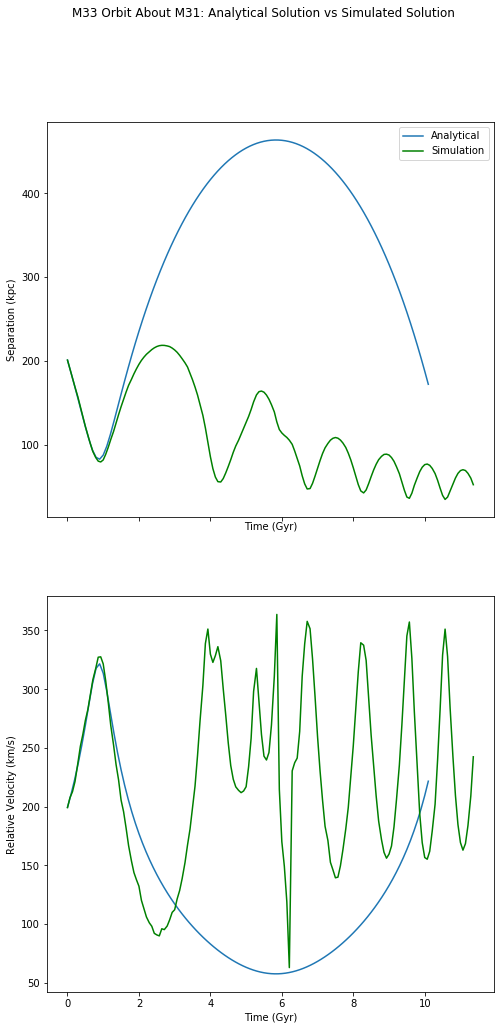

In [64]:
"""Generate data from data files"""
filename = 'M33_AnalyticOrbit.txt'
Data = np.genfromtxt(filename, names = True)
M33_Data = np.genfromtxt('Orbit_M33.txt',names=True)
M31_Data = np.genfromtxt('Orbit_M31.txt',names=True)
"""Stores the relative position and velocity between M31 and M33"""
t = M33_Data['time']
x = M33_Data['x'] - M31_Data['x']
y = M33_Data['y'] - M31_Data['y']
z = M33_Data['z'] - M31_Data['z']
vx = M33_Data['vx'] - M31_Data['vx']
vy = M33_Data['vy'] - M31_Data['vy']
vz = M33_Data['vz'] - M31_Data['vz']
"""Position Plots"""
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (8,16), sharex ='all')
fig.suptitle("M33 Orbit About M31: Analytical Solution vs Simulated Solution")
ax[0].plot(Data['t'], np.linalg.norm([Data['x'],Data['y'],Data['z']],axis=0), label="Analytical")
ax[0].set_xlabel('Time (Gyr)')
ax[0].set_ylabel('Separation (kpc)')
"""Revaltive Velocity Plot"""
ax[1].plot(Data['t'], np.linalg.norm([Data['vx'],Data['vy'],Data['vz']],axis=0),label="Analytical")
ax[1].set_xlabel('Time (Gyr)')
ax[1].set_ylabel('Relative Velocity (km/s)')
ax[0].plot(t, np.linalg.norm([x,y,z],axis=0), color='green', label='Simulation')
#Plot the velocity between M31 and M33
ax[1].plot(t, np.linalg.norm([vx,vy,vz],axis=0),color='green', label='Simulation')
ax[0].legend()
plt.show()

#2 The analytical data for position shows that M33 will move away from M33 and then move in after roughly 5Gyr, while the simulated data shows that M33 will move in and out from M33, with each pass taking it closer than the last. The orbits differ in that the Analytical data shows that velocity will rise and then fall to a minimum after about 5.5Gyr and then rise back up to the starting value, while the Simulated data shows a much more varried orbit with the velocity rising and falling as M33 gets closer and farther away from M31.
#3 The gravitational interactions between the gass in the galaxies could account for the differences seen in the plots. This drag from the surrounding matter could cause M33 to slow its orbit and become trapped by M31.
#4 Since the Milky Way is not considered in this analytical solution, we are missing the interactions between the three galaxies as they approach each other. If we include MW in the calculations M33 might be have a more extreme orbit as it will be impacted by both MW and M31. Once MW and M31 begin to pass through each other and begin to merge, M33 could fall into one of the larger galaxies at a faster more irradic pace due to the higher concentration of mass.